In [1]:
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from keras.applications import ResNet50
import imgaug as ia
import imgaug.augmenters as iaa
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from Reader import read_dataset

tf.get_logger().setLevel(3)
import cv2
import os, glob
import pandas as pd
import Helper

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42

In [3]:
def create_model(channel_size=3):
    input_shape = []
    if channel_size == 3:  #RGB or XYZ channels
        input_shape = [IMAGE_WIDTH, IMAGE_HEIGHT, channel_size]
    elif channel_size == 1:  #Grayscaled images
        input_shape = [IMAGE_WIDTH, IMAGE_HEIGHT, 1]
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(),
        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(),
        Flatten(),
        Dropout(0.4),
        Dense(1024, activation="relu"),
        Dense(4, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                  metrics=['accuracy'])

    return model

In [4]:
#Display the model layers
model_display = create_model()
model_display.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [5]:
def strafied_kfold(model, X_train, y_train, X_test, y_test):
    # Define a StratifiedKFold object
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    acc = []
    val_acc = []
    test_acc = []
    loss = []
    val_loss = []
    test_loss = []
    # Iterate over the K folds
    counter = 1
    for train_index, test_index in skf.split(X_train, np.argmax(y_train, axis=1)):
        print(f"--------------------{counter}. Epoch----------------------")
        counter += 1
        # Split the data into K folds
        X_fold_train, X_fold_val = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[test_index]
        # Train and evaluate the model on the fold
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3, verbose=1)
        history = model.fit(X_fold_train, y_fold_train,
                            validation_data=(X_fold_val, y_fold_val),
                            epochs=6,
                            batch_size=BATCH_SIZE,
                            steps_per_epoch=len(X_fold_train) / BATCH_SIZE)
        score = model.evaluate(X_test, y_test, verbose=1)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        acc = np.concatenate((acc, history.history['accuracy']), axis=None)
        val_acc = np.concatenate((val_acc, history.history['val_accuracy']), axis=None)
        loss = np.concatenate((loss, history.history['loss']), axis=None)
        val_loss = np.concatenate((val_loss, history.history['val_loss']), axis=None)
        test_acc.append(score[1])
        test_loss.append(score[0])
    return model, acc, val_acc, loss, val_loss, test_acc, test_loss

In [13]:
techniques = ["Default", "Color Normalization", "Canny Edge", "Gray Scale", "XYZ", "HSV", "Binarization"]
single_channels = ["Canny Edge", "Gray Scale", "Binarization"]

******************************************************************************************************************
--------------------1. Epoch----------------------
Epoch 1/6
36/36 [==============================] - 93s 3s/step - loss: 4.4592 - accuracy: 0.4123 - val_loss: 8.4823 - val_accuracy: 0.1667
Epoch 2/6
36/36 [==============================] - 86s 2s/step - loss: 1.1079 - accuracy: 0.5582 - val_loss: 14.9172 - val_accuracy: 0.1667
Epoch 3/6
36/36 [==============================] - 86s 2s/step - loss: 0.9357 - accuracy: 0.6146 - val_loss: 18.0782 - val_accuracy: 0.1667
Epoch 4/6
36/36 [==============================] - 85s 2s/step - loss: 0.8189 - accuracy: 0.6502 - val_loss: 16.9518 - val_accuracy: 0.1667
Epoch 5/6
36/36 [==============================] - 84s 2s/step - loss: 0.7503 - accuracy: 0.6884 - val_loss: 15.6263 - val_accuracy: 0.1667
Epoch 6/6
12/12 [==============================] - 6s 511ms/step - loss: 8.9150 - accuracy: 0.1653
Test loss: 8.915048599243164
Test ac

ValueError: in user code:

    File "C:\Users\tekel\PycharmProjects\My_Project\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\tekel\PycharmProjects\My_Project\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\tekel\PycharmProjects\My_Project\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\tekel\PycharmProjects\My_Project\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\tekel\PycharmProjects\My_Project\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\tekel\PycharmProjects\My_Project\venv\lib\site-packages\keras\engine\input_spec.py", line 250, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_8" "                 f"(type Sequential).
    
    Input 0 of layer "conv2d_32" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (32, 224, 224)
    
    Call arguments received by layer "sequential_8" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(32, 224, 224), dtype=float32)
      • training=True
      • mask=None


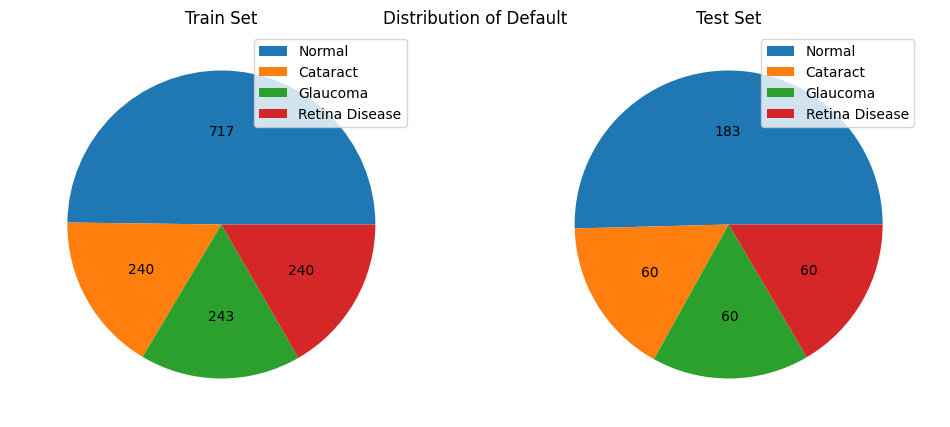

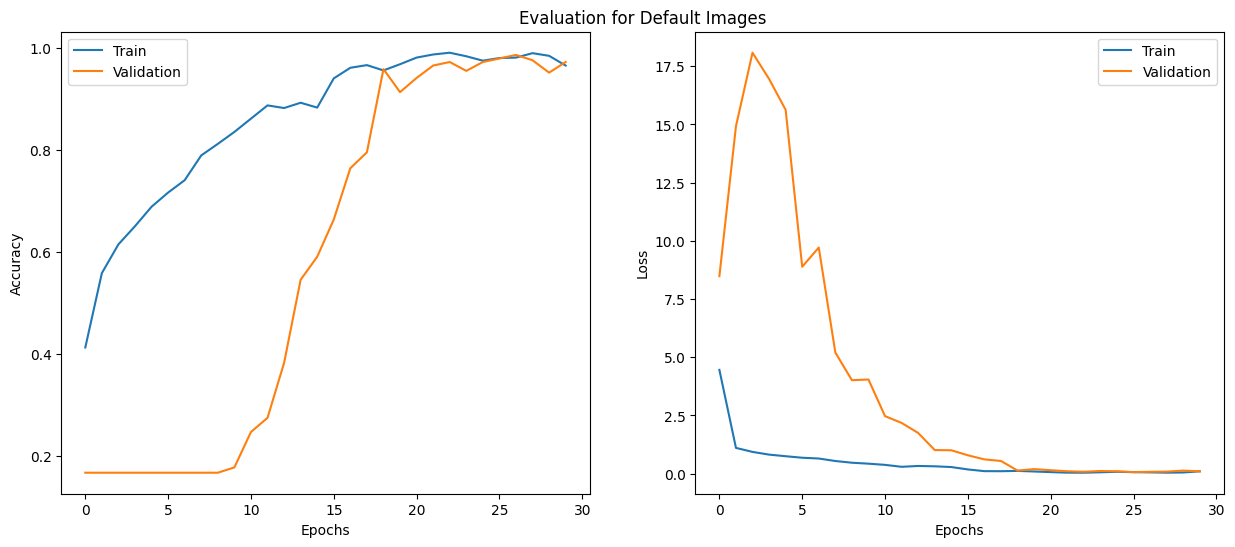

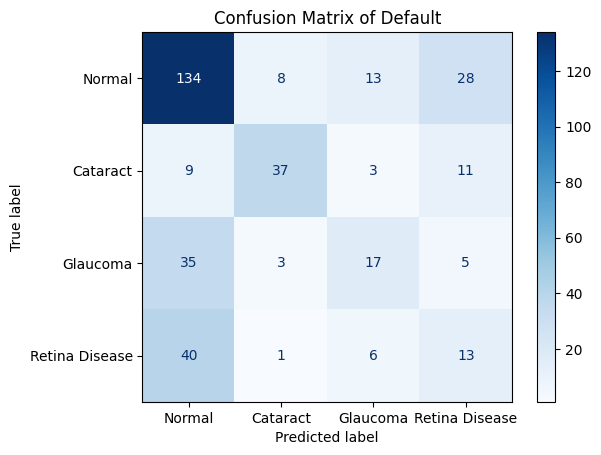

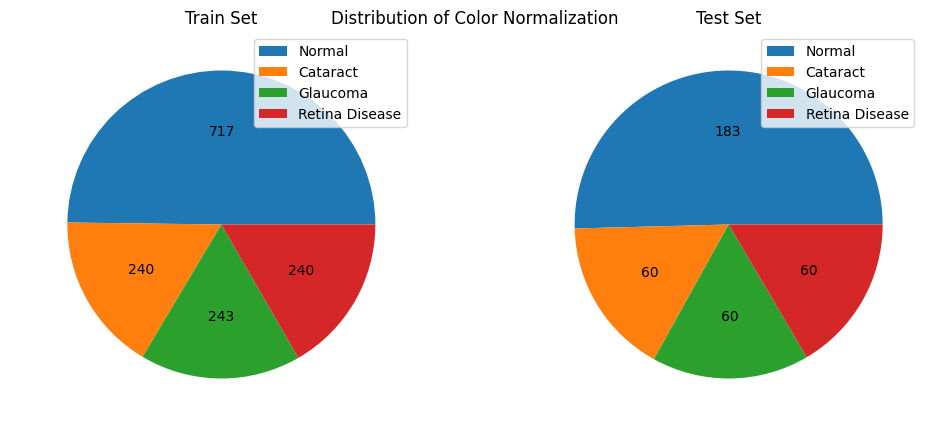

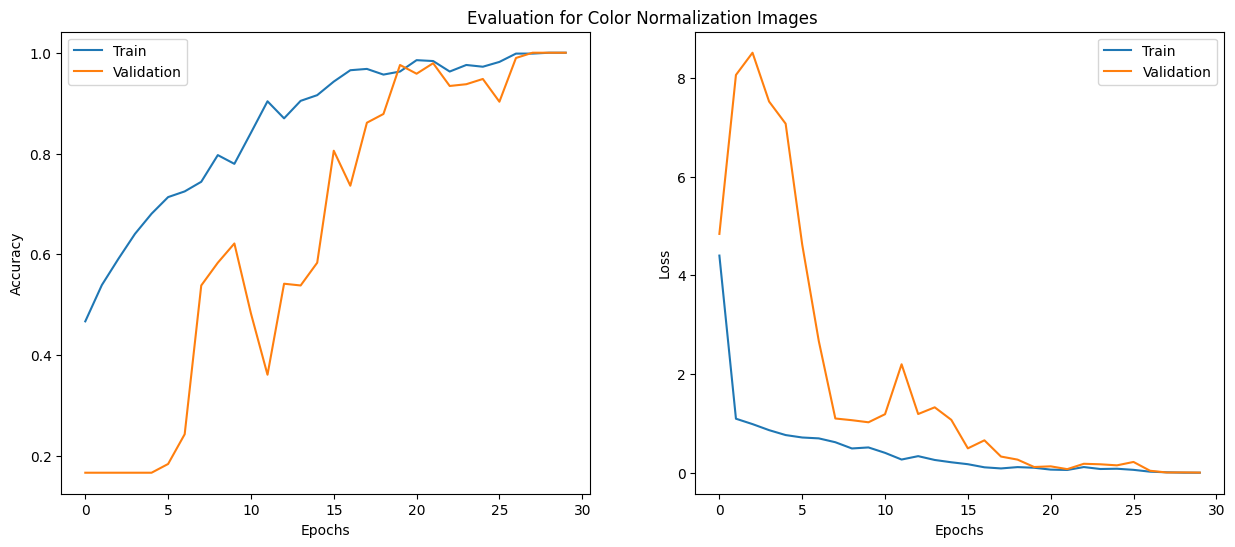

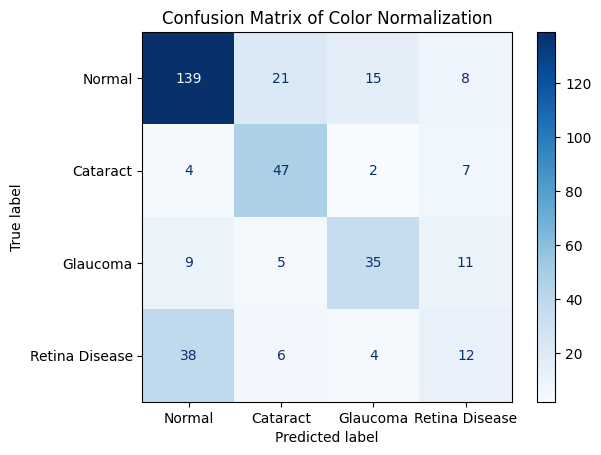

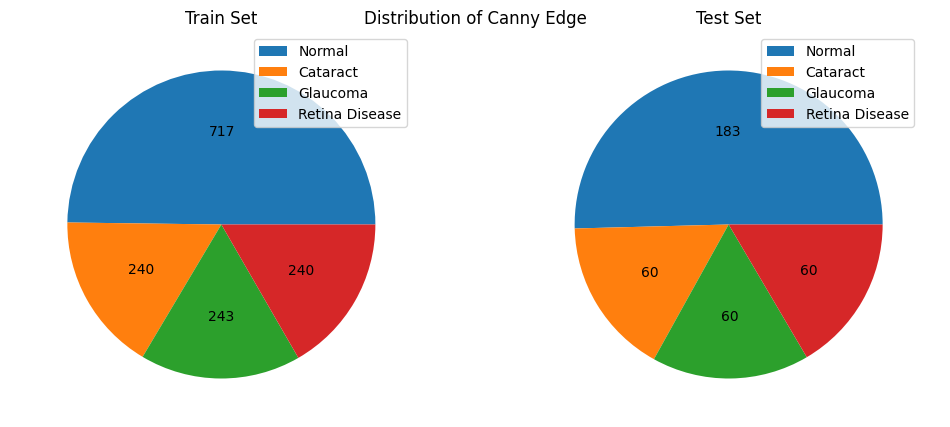

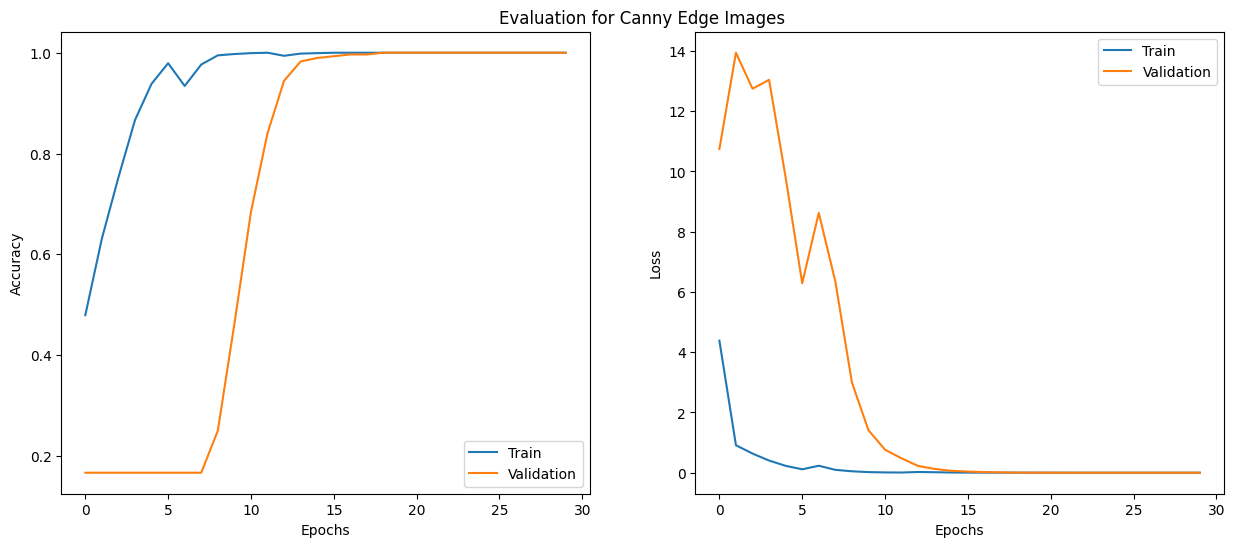

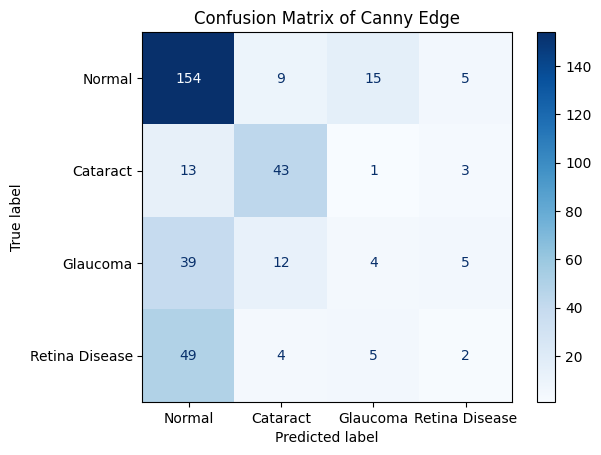

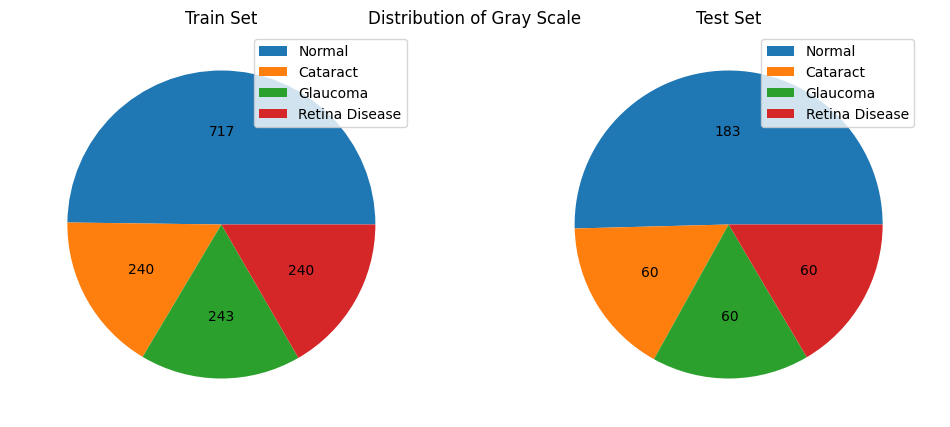

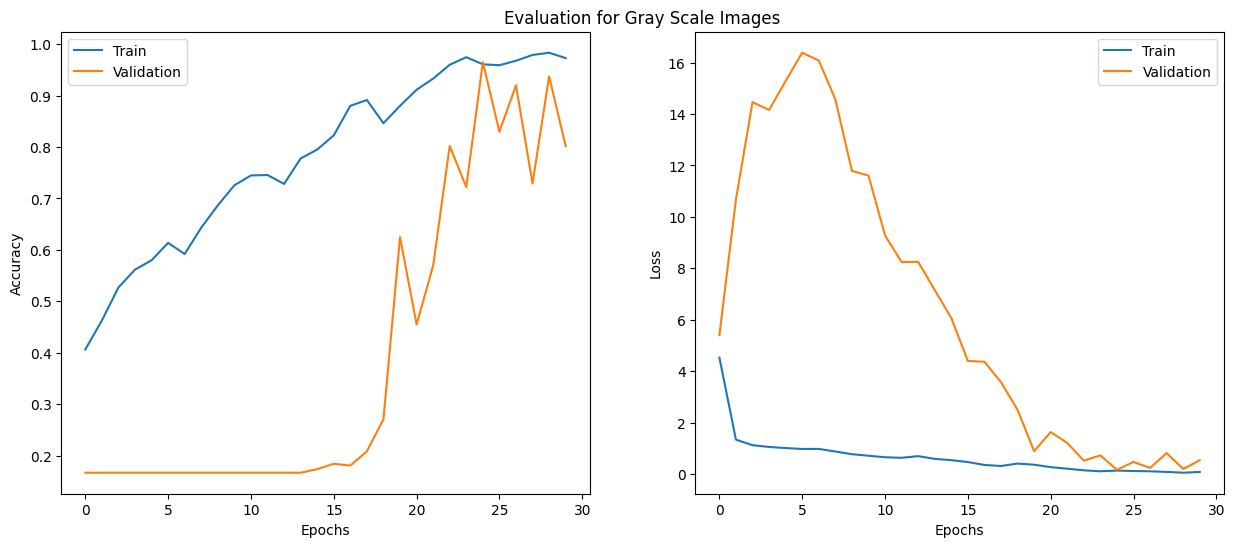

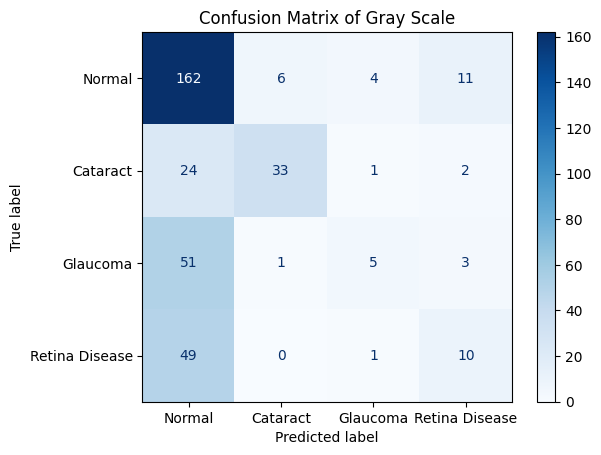

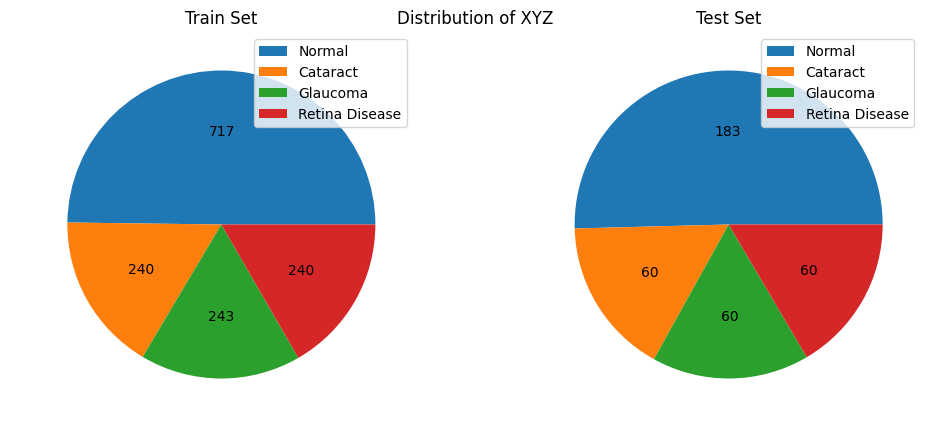

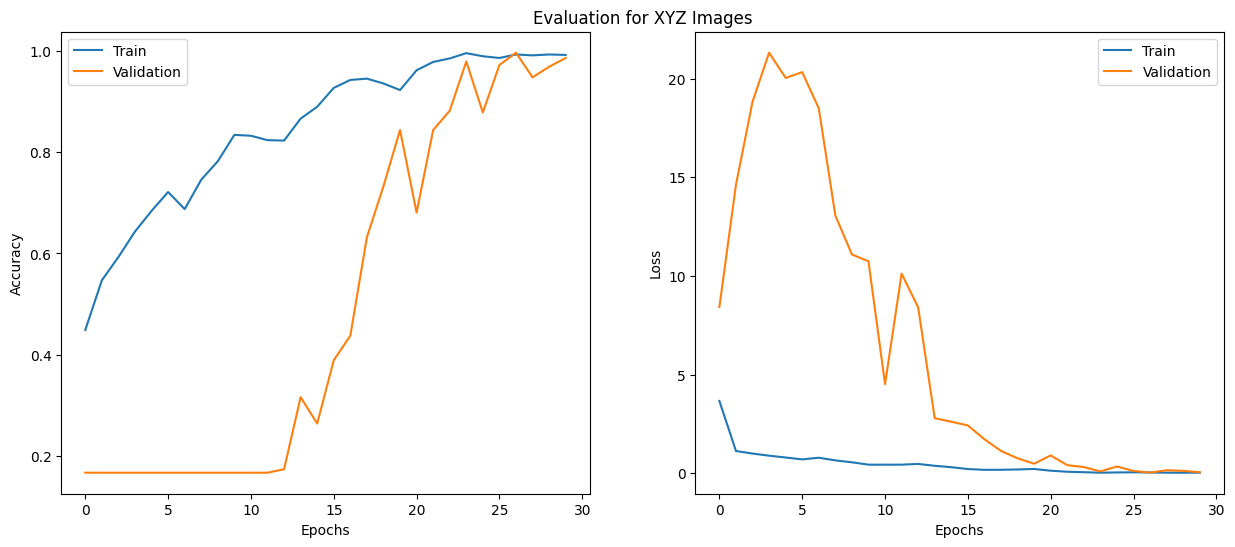

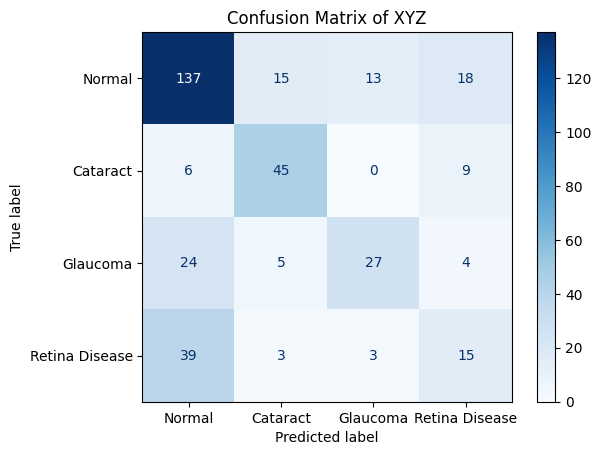

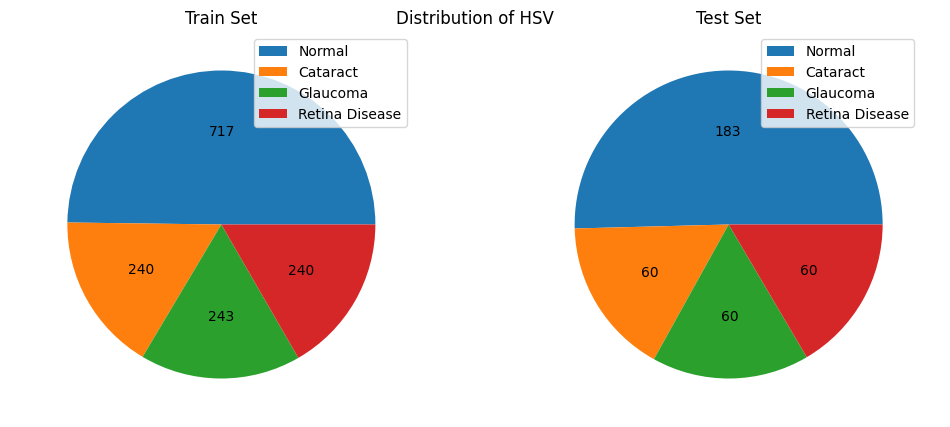

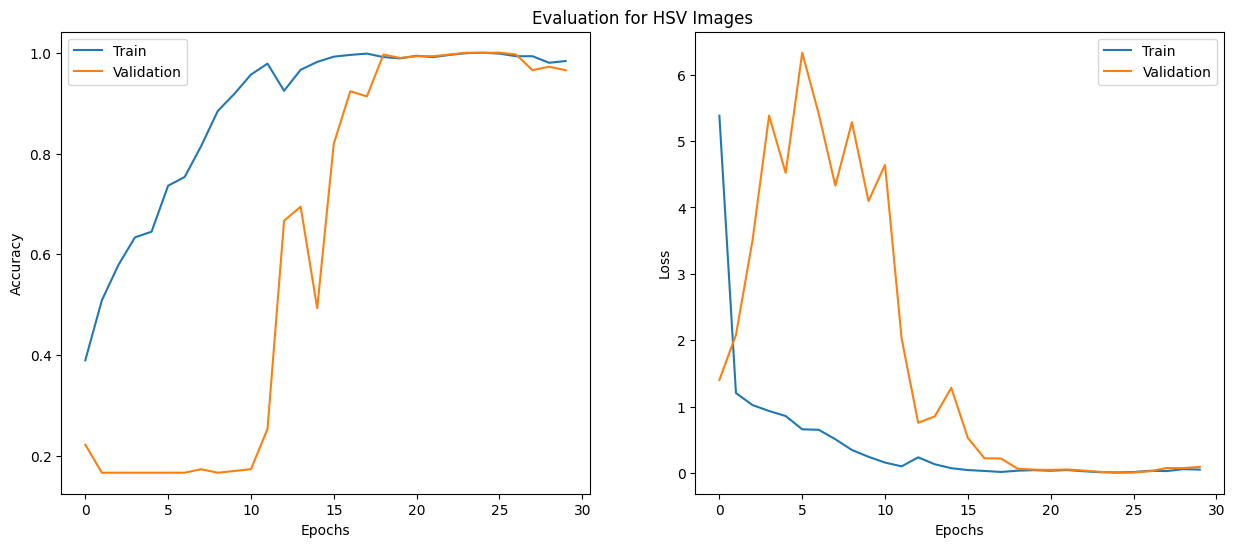

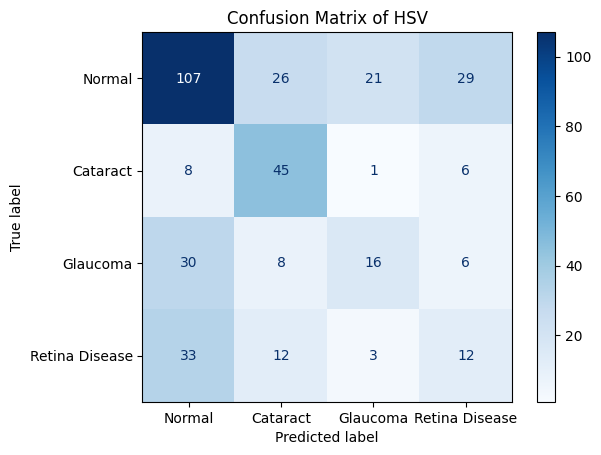

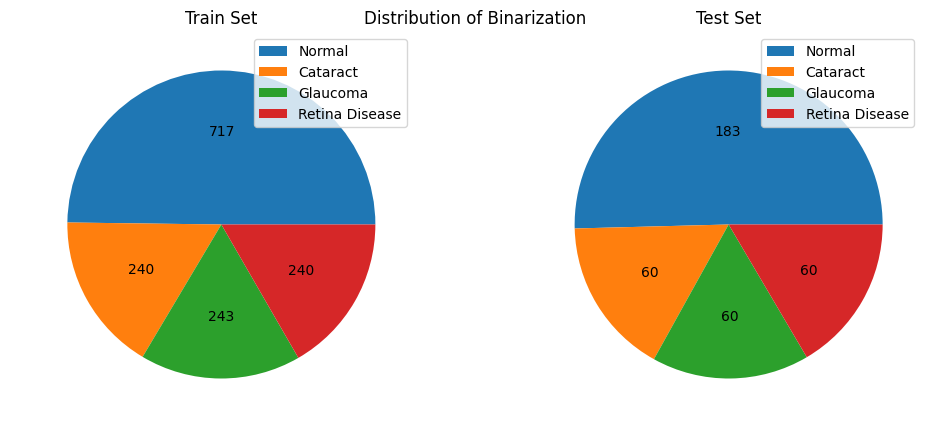

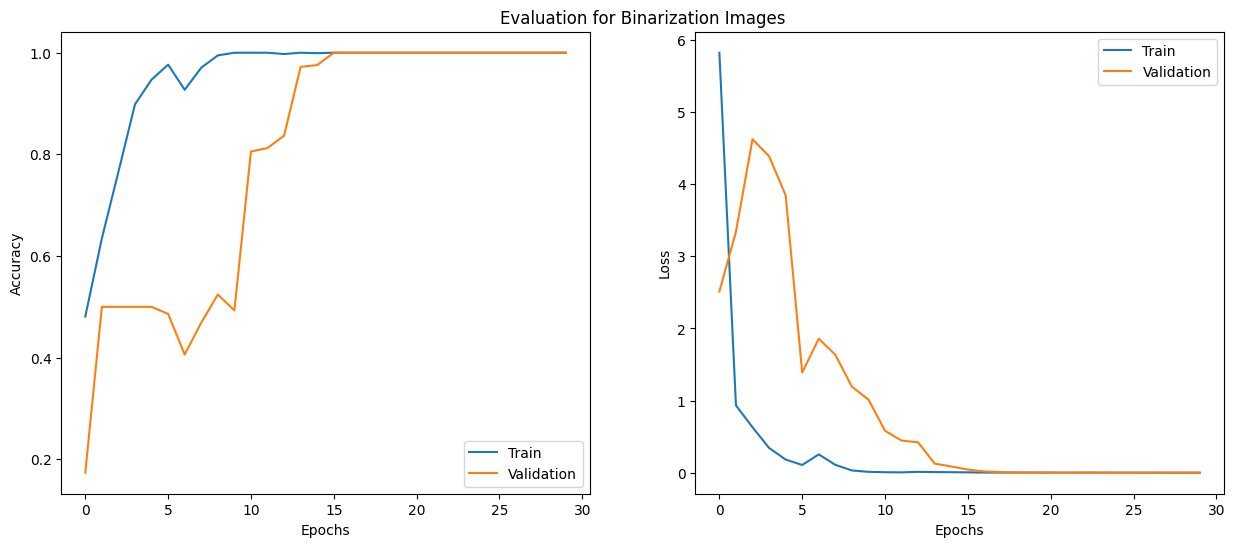

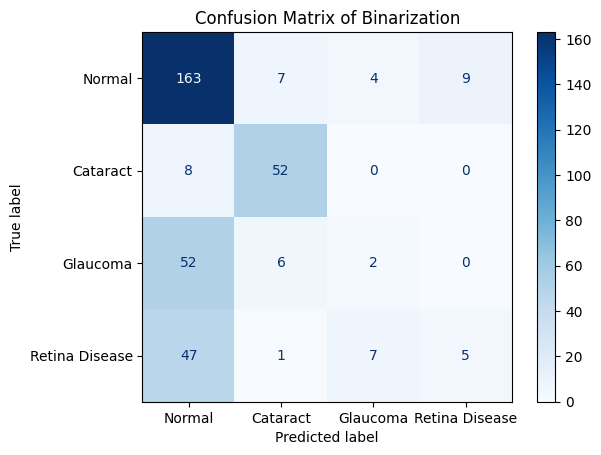

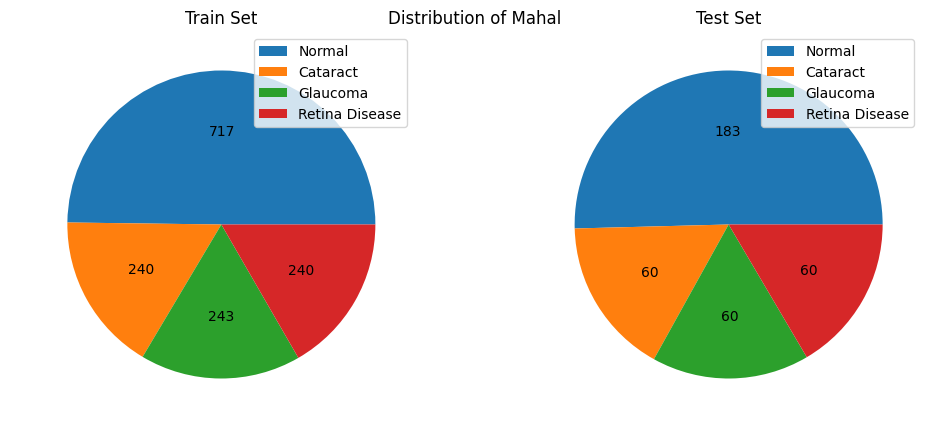

In [7]:
dict_sens = {}
dict_spec = {}
dict_acc = {}
dict_loss = {}
for i, technique in enumerate(techniques):
    X_train, y_train, X_test, y_test = read_dataset(mode=i)
    Helper.plot_pie_sets([np.argmax(y_train, axis=1), np.argmax(y_test, axis=1)], technique)
    if technique in single_channels:
        model = create_model(channel_size=1)
    else:
        model = create_model()
    print("******************************************************************************************************************")
    model, acc, val_acc, loss, val_loss, test_acc, test_loss = strafied_kfold(model, X_train, y_train, X_test, y_test)
    dict_acc[technique] = test_acc
    dict_loss[technique] = test_loss
    Helper.plot_history([acc, val_acc, loss, val_loss], technique)
    sensitivity, specificity = Helper.plot_conf_matrix(model, X_test, y_test, technique)
    dict_sens[technique] = sensitivity
    dict_spec[technique] = specificity

In [8]:
classes = list(dict_sens.keys())
values1 = list(dict_sens.values())
values2 = list(dict_spec.values())

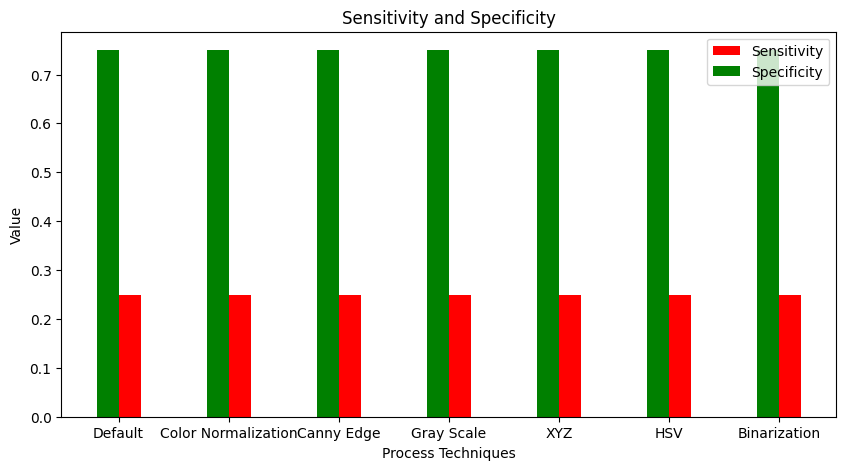

In [9]:
fig = plt.figure(figsize=(10, 5))

# creating the bar plot
plt.bar(classes, values1, color='red',
        width=0.2, label="Sensitivity", align="edge")
plt.bar(classes, values2, color='green',
        width=-0.2, label="Specificity", align="edge")

plt.xlabel("Process Techniques")
plt.ylabel("Value")
plt.title("Sensitivity and Specificity")
plt.legend(loc=0)
plt.show()

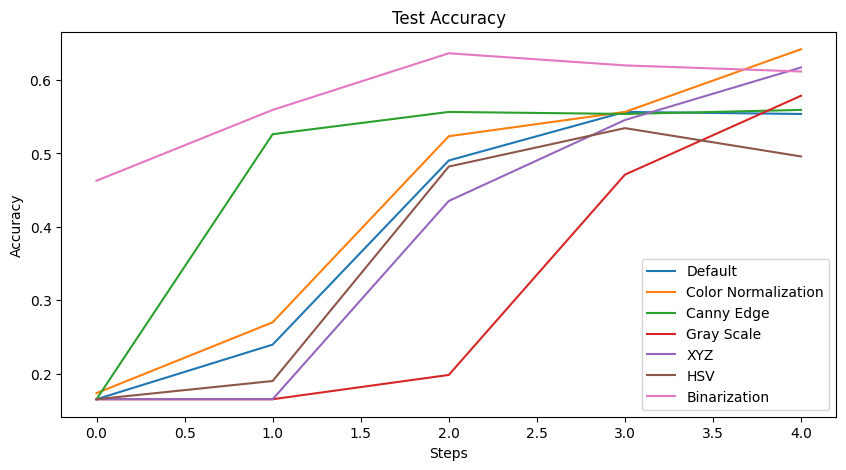

<Figure size 640x480 with 0 Axes>

In [14]:
fig = plt.figure(figsize=(10, 5))
for technique in techniques:
    plt.plot(dict_acc[technique])
plt.title("Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Steps")
plt.legend(techniques, loc=0)
plt.show()
plt.savefig("result_acc.png")

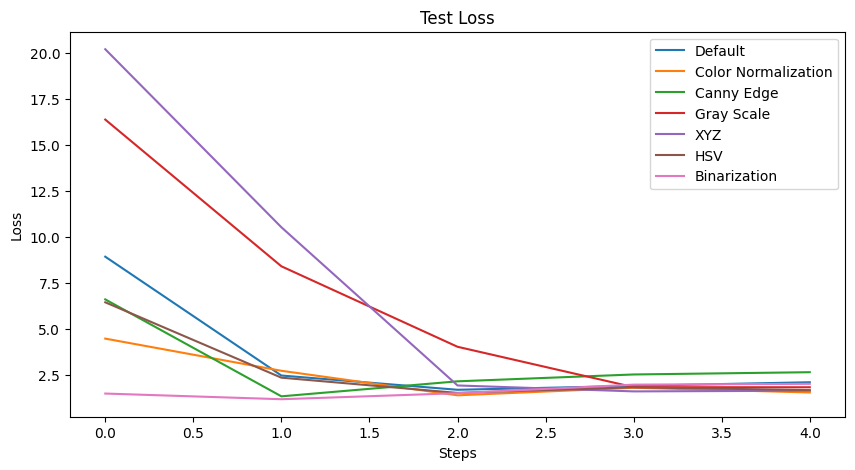

<Figure size 640x480 with 0 Axes>

In [16]:
fig = plt.figure(figsize=(10, 5))
for technique in techniques:
    plt.plot(dict_loss[technique])
plt.title("Test Loss")
plt.ylabel("Loss")
plt.xlabel("Steps")
plt.legend(techniques, loc=0)
plt.show()
plt.savefig("result_loss.png")